# Crypto Altcoin Analysis
This workbook will walk through extracting data from Coinbase on all altcoins available with a USD pairing, then clean data and do some performance and correlation analysis.



In [24]:
# Imports
import panel as pn
pn.extension('plotly')
import plotly.express as px
import numpy as np
import pandas as pd
import hvplot.pandas
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import os
from pathlib import Path
from dotenv import load_dotenv
import csv
import cbpro
import requests
import time


In [25]:
# Setup Public Client for Coinbase
public_client = cbpro.PublicClient()

In [26]:
# Pull a list of all currencies (Assets and pairings)
currency_response_list = public_client.get_currencies()

In [27]:
# Pull only the assets that are marked as crypto

# Create empty list of cryptos
crypto_list = []

# If the asset is labeled as a crypto add to crypto list
for asset in currency_response_list:
    if asset['details']['type'] == 'crypto':
        crypto_list.append(asset['id'])
crypto_list.sort()
print(crypto_list)
print(len(crypto_list))

['1INCH', 'AAVE', 'ACH', 'ADA', 'ALGO', 'AMP', 'ANKR', 'ATOM', 'BAL', 'BAND', 'BAT', 'BCH', 'BNT', 'BOND', 'BTC', 'CGLD', 'CHZ', 'CLV', 'COMP', 'CRV', 'CTSI', 'CVC', 'DAI', 'DASH', 'DNT', 'DOGE', 'DOT', 'ENJ', 'EOS', 'ETC', 'ETH', 'FARM', 'FET', 'FIL', 'FORTH', 'GNT', 'GRT', 'GTC', 'ICP', 'KEEP', 'KNC', 'LINK', 'LOOM', 'LPT', 'LRC', 'LTC', 'MANA', 'MASK', 'MATIC', 'MIR', 'MKR', 'MLN', 'NKN', 'NMR', 'NU', 'OGN', 'OMG', 'OXT', 'PAX', 'PLA', 'POLY', 'QNT', 'RAI', 'REN', 'REP', 'RLC', 'RLY', 'SHIB', 'SKL', 'SNX', 'SOL', 'STORJ', 'SUSHI', 'TRB', 'UMA', 'UNI', 'USDC', 'USDT', 'WBTC', 'XLM', 'XRP', 'XTZ', 'YFI', 'ZEC', 'ZRX']
85


In [5]:
# Get a list of all Coinbase Products
all_products_list = public_client.get_products()
print(len(all_products_list))
#all_products_list

246


In [6]:
# Find product ids that have a USD quote_currency and create a list

# Create Empty List for USD paired products
usd_product_id_list = []
for product in all_products_list:
    if product['quote_currency'] == 'USD':
        usd_product_id_list.append(product['id'])
usd_product_id_list.sort()
print(usd_product_id_list)

['1INCH-USD', 'AAVE-USD', 'ACH-USD', 'ADA-USD', 'ALGO-USD', 'AMP-USD', 'ANKR-USD', 'ATOM-USD', 'BAL-USD', 'BAND-USD', 'BAT-USD', 'BCH-USD', 'BNT-USD', 'BOND-USD', 'BTC-USD', 'CGLD-USD', 'CHZ-USD', 'CLV-USD', 'COMP-USD', 'CRV-USD', 'CTSI-USD', 'DAI-USD', 'DASH-USD', 'DOGE-USD', 'DOT-USD', 'ENJ-USD', 'EOS-USD', 'ETC-USD', 'ETH-USD', 'FARM-USD', 'FET-USD', 'FIL-USD', 'FORTH-USD', 'GRT-USD', 'GTC-USD', 'ICP-USD', 'KEEP-USD', 'KNC-USD', 'LINK-USD', 'LPT-USD', 'LRC-USD', 'LTC-USD', 'MANA-USD', 'MASK-USD', 'MATIC-USD', 'MIR-USD', 'MKR-USD', 'MLN-USD', 'NKN-USD', 'NMR-USD', 'NU-USD', 'OGN-USD', 'OMG-USD', 'OXT-USD', 'PAX-USD', 'PLA-USD', 'POLY-USD', 'QNT-USD', 'RAI-USD', 'REN-USD', 'REP-USD', 'RLC-USD', 'RLY-USD', 'SKL-USD', 'SNX-USD', 'SOL-USD', 'STORJ-USD', 'SUSHI-USD', 'TRB-USD', 'UMA-USD', 'UNI-USD', 'USDT-USD', 'WBTC-USD', 'XLM-USD', 'XTZ-USD', 'YFI-USD', 'ZEC-USD', 'ZRX-USD']


In [7]:
# Make calls to the Products endpoint for each product_Id and pull candlestick data for the last 300 weeks
# GET https://api.pro.coinbase.com/products/<product-id>/candles
# Reponses contain the following metrics in a list of lists.
# [0] time bucket start time
# [1] low lowest price during the bucket interval
# [2] high highest price during the bucket interval
# [3] open opening price (first trade) in the bucket interval
# [4] close closing price (last trade) in the bucket interval
# [5] volume volume of trading activity during the bucket interval
# columns1 = ['Date'] + usd_product_id_list

def pull_historical_data(start,end):
    temp_df = pd.DataFrame()
    for item in good_list:
        historical = pd.DataFrame(public_client.get_product_historic_rates(item, start=start, end=end, granularity=86400))
        historical.columns=["Date","Open","High","Low",item,"Volume"]
        historical['Date'] = pd.to_datetime(historical['Date'], unit='s')
        historical.set_index('Date', inplace=True)
        historical.sort_values(by='Date', ascending=True, inplace=True)
        historical = historical.drop(['Open', 'High', 'Low', 'Volume'], axis=1)
        temp_df = pd.concat([temp_df, historical], axis=1)
    # print(f"temp_df 1: {temp_df}")
    return temp_df


main_df = pd.DataFrame()

# Apparently only some of these product ID's have data going back to 2019 - these are those
good_list = ['ALGO-USD', 'BCH-USD', 'BTC-USD', 'DASH-USD', 'EOS-USD', 'ETC-USD', 'ETH-USD', 'LINK-USD', 'LTC-USD', 'REP-USD', 'XLM-USD', 'XTZ-USD', 'ZRX-USD']        
    

date_start1 = '2019-01-01T00:00:00-06:00'
date_end1 = '2019-10-19T00:00:00-05:00'
date_start2 = '2019-10-20T00:00:00-06:00'
date_end2 = '2020-05-19T00:00:00-05:00'
date_start3 = '2020-05-20T00:00:00-06:00'
date_end3 ='2020-10-19T00:00:00-05:00'
date_start4 = '2020-10-20T00:00:00-06:00'
date_end4 = '2021-05-19T00:00:00-05:00'
date_start5 = '2021-05-20T00:00:00-06:00'
date_end5 ='2021-08-04T00:00:00-05:00'

main_df = pull_historical_data(date_start1, date_end1)
# clean up null values
main_df = main_df.dropna()
temp_df = pull_historical_data(date_start2, date_end2)
main_df = pd.concat([main_df, temp_df], axis=0)
temp_df = pull_historical_data(date_start3, date_end3)
main_df = pd.concat([main_df, temp_df], axis=0)
temp_df = pull_historical_data(date_start4, date_end4)
main_df = pd.concat([main_df, temp_df], axis=0)
temp_df = pull_historical_data(date_start5, date_end5)
main_df = pd.concat([main_df, temp_df], axis=0)

main_df


,ALGO-USD,BCH-USD,BTC-USD,DASH-USD,EOS-USD,ETC-USD,ETH-USD,LINK-USD,LTC-USD,REP-USD,XLM-USD,XTZ-USD,ZRX-USD
Date,,,,,,,,,,,,,
2019-09-17,0.3190,318.18,10185.39,94.337,4.067,6.279,207.95,1.62707,74.13,10.61,0.063411,1.1104,0.174939
2019-09-18,0.3411,324.04,10155.26,97.646,4.081,6.388,210.27,1.80999,77.75,10.73,0.082876,1.0861,0.192772
2019-09-19,0.3222,323.80,10275.01,99.935,3.968,6.226,220.80,1.87800,76.82,10.71,0.080944,1.0891,0.228500
2019-09-20,0.3201,315.75,10168.85,96.650,4.014,6.160,218.06,1.82052,75.10,10.91,0.071933,1.0628,0.232041
2019-09-21,0.3157,311.60,9973.99,92.817,3.997,6.114,214.80,1.88000,73.18,10.75,0.069626,1.0725,0.247124
2019-09-22,0.3003,306.75,10026.80,90.764,3.812,5.990,211.10,1.81940,72.26,10.47,0.068589,1.0479,0.237211
2019-09-23,0.2674,292.06,9693.74,86.545,3.682,5.809,200.80,1.80177,66.47,10.53,0.063373,1.0530,0.208438
2019-09-24,0.1947,246.26,8530.01,72.083,2.774,4.964,166.26,1.72850,55.50,8.93,0.054151,0.9199,0.191351
2019-09-25,0.2050,227.90,8438.35,73.423,2.865,4.860,170.00,1.75001,57.53,8.62,0.057395,0.8526,0.213803


# Crypto Altcoin Analysis
This workbook will walk through extracting data from Coinbase on all altcoins available with a USD pairing, then clean data and do some performance and correlation analysis.



In [8]:
main_df = main_df.dropna()
main_df


,ALGO-USD,BCH-USD,BTC-USD,DASH-USD,EOS-USD,ETC-USD,ETH-USD,LINK-USD,LTC-USD,REP-USD,XLM-USD,XTZ-USD,ZRX-USD
Date,,,,,,,,,,,,,
2019-09-17,0.3190,318.18,10185.39,94.337,4.067,6.279,207.95,1.62707,74.13,10.61,0.063411,1.1104,0.174939
2019-09-18,0.3411,324.04,10155.26,97.646,4.081,6.388,210.27,1.80999,77.75,10.73,0.082876,1.0861,0.192772
2019-09-19,0.3222,323.80,10275.01,99.935,3.968,6.226,220.80,1.87800,76.82,10.71,0.080944,1.0891,0.228500
2019-09-20,0.3201,315.75,10168.85,96.650,4.014,6.160,218.06,1.82052,75.10,10.91,0.071933,1.0628,0.232041
2019-09-21,0.3157,311.60,9973.99,92.817,3.997,6.114,214.80,1.88000,73.18,10.75,0.069626,1.0725,0.247124
2019-09-22,0.3003,306.75,10026.80,90.764,3.812,5.990,211.10,1.81940,72.26,10.47,0.068589,1.0479,0.237211
2019-09-23,0.2674,292.06,9693.74,86.545,3.682,5.809,200.80,1.80177,66.47,10.53,0.063373,1.0530,0.208438
2019-09-24,0.1947,246.26,8530.01,72.083,2.774,4.964,166.26,1.72850,55.50,8.93,0.054151,0.9199,0.191351
2019-09-25,0.2050,227.90,8438.35,73.423,2.865,4.860,170.00,1.75001,57.53,8.62,0.057395,0.8526,0.213803


In [9]:
main_df.isnull

<bound method DataFrame.isnull of             ALGO-USD  BCH-USD   BTC-USD  DASH-USD  EOS-USD  ETC-USD  ETH-USD  \
Date                                                                           
2019-09-17    0.3190   318.18  10185.39    94.337    4.067    6.279   207.95   
2019-09-18    0.3411   324.04  10155.26    97.646    4.081    6.388   210.27   
2019-09-19    0.3222   323.80  10275.01    99.935    3.968    6.226   220.80   
2019-09-20    0.3201   315.75  10168.85    96.650    4.014    6.160   218.06   
2019-09-21    0.3157   311.60   9973.99    92.817    3.997    6.114   214.80   
2019-09-22    0.3003   306.75  10026.80    90.764    3.812    5.990   211.10   
2019-09-23    0.2674   292.06   9693.74    86.545    3.682    5.809   200.80   
2019-09-24    0.1947   246.26   8530.01    72.083    2.774    4.964   166.26   
2019-09-25    0.2050   227.90   8438.35    73.423    2.865    4.860   170.00   
2019-09-26    0.1900   214.11   8060.00    68.849    2.780    4.755   165.85   
2019-0

In [10]:
main_df.isnull().sum()

ALGO-USD    0
BCH-USD     0
BTC-USD     0
DASH-USD    0
EOS-USD     0
ETC-USD     0
ETH-USD     0
LINK-USD    0
LTC-USD     0
REP-USD     0
XLM-USD     0
XTZ-USD     0
ZRX-USD     0
dtype: int64

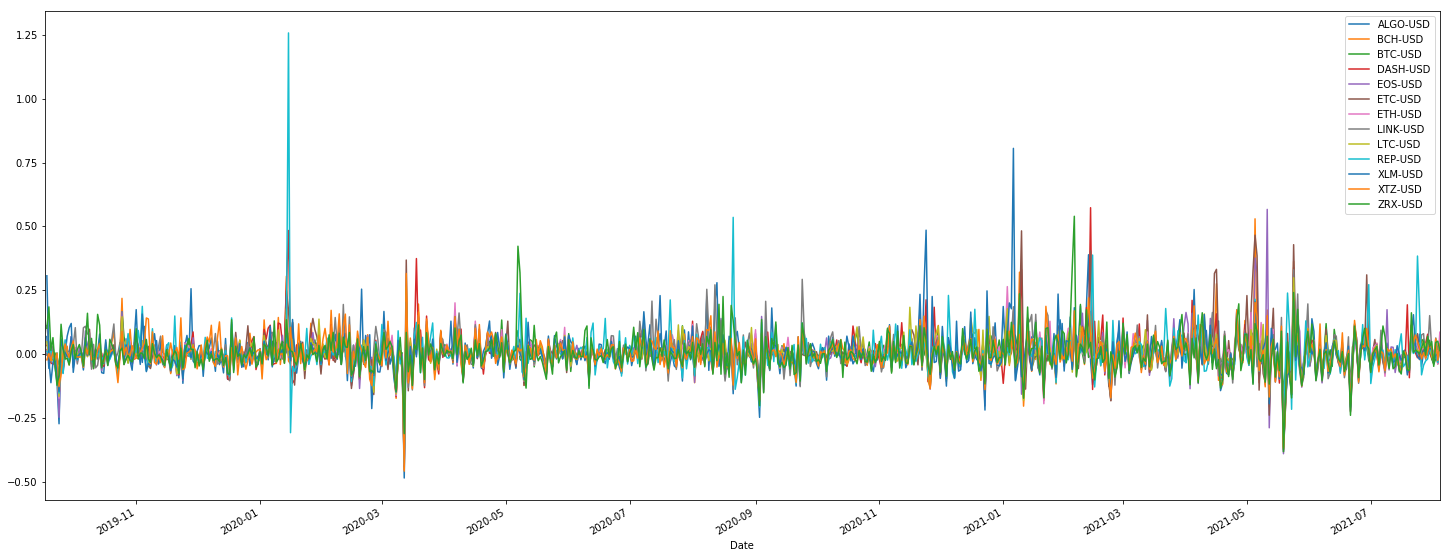

In [11]:
main_crypto_change = main_df.pct_change()
main_crypto_change.plot(figsize=(25,10))

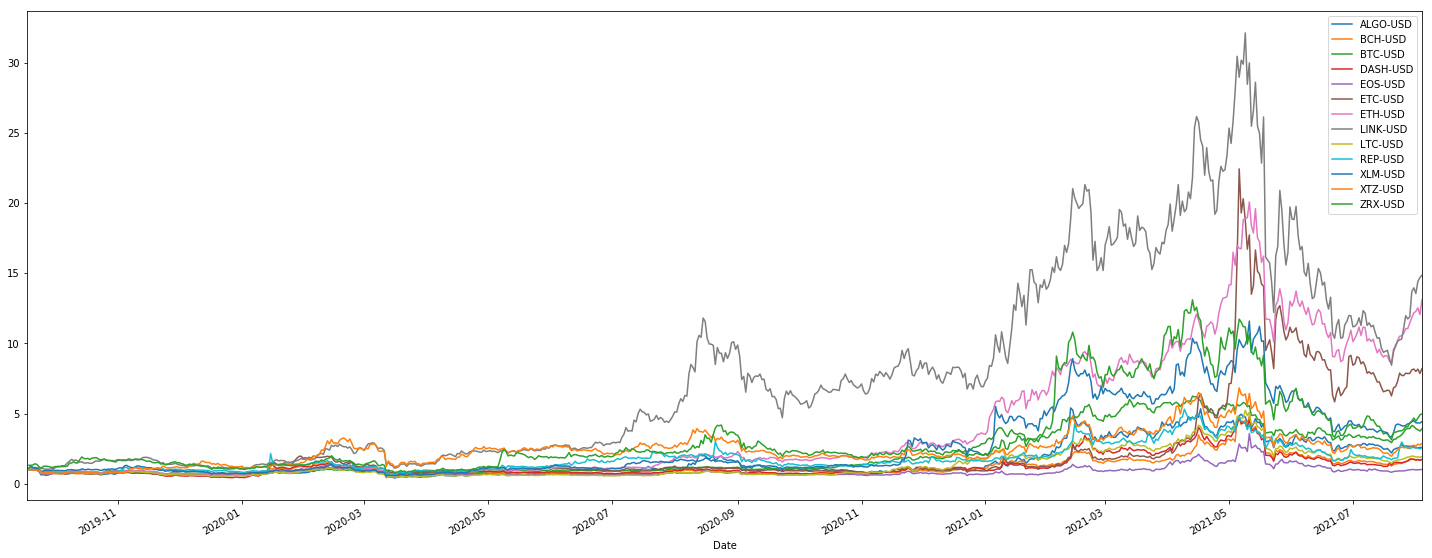

In [12]:
# Calculate cumulative returns of all portfolios
cumulative_returns = (1 + main_crypto_change).cumprod() 
cumulative_returns
# Plot cumulative returns
cumulative_returns.plot(figsize=(25,10))

In [13]:
final_alt_returns = cumulative_returns[-1:]
final_alt_returns

,ALGO-USD,BCH-USD,BTC-USD,DASH-USD,EOS-USD,ETC-USD,ETH-USD,LINK-USD,LTC-USD,REP-USD,XLM-USD,XTZ-USD,ZRX-USD
Date,,,,,,,,,,,,,
2021-08-04,2.597492,1.714816,3.89994,1.713315,1.013278,8.205606,13.102717,14.872593,1.922838,2.548539,4.425226,2.85915,4.9755


## Figure out how to PLot bar chart with x-axes as the ALt pairings - Pete

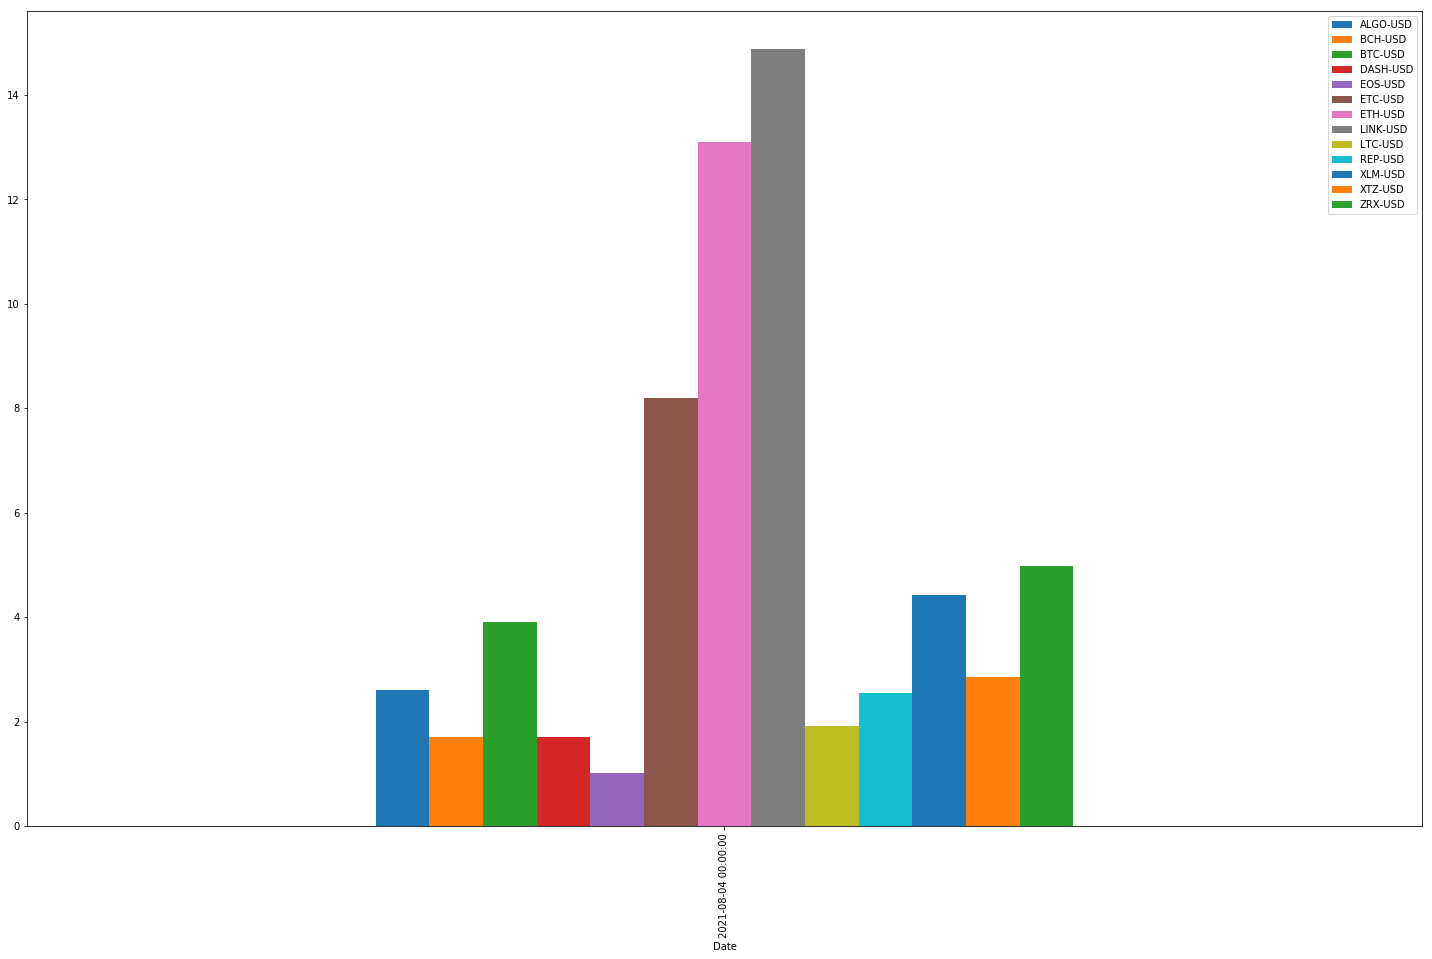

In [14]:
final_alt_returns.plot( kind='bar', figsize=(25,15))

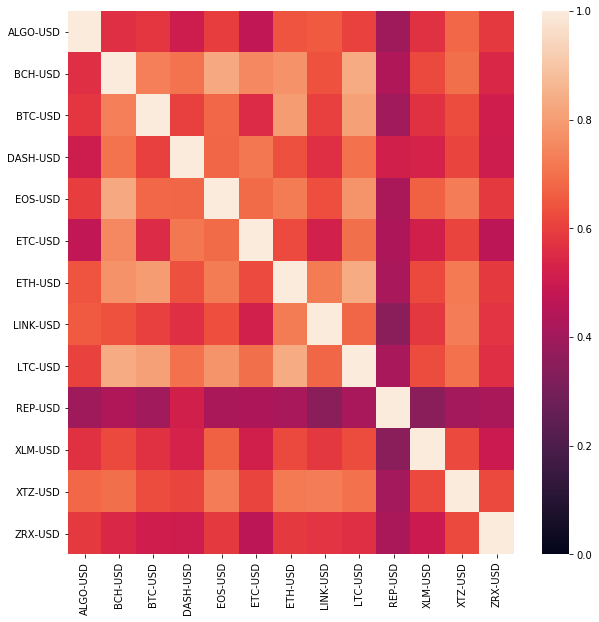

In [15]:
import seaborn as sns
correlation = main_crypto_change.corr()
# Display de correlation matrix
fig, ax = plt.subplots(figsize=(10,10))         # Sample figsize in inches
#sns.heatmap(df1.iloc[:, 1:6:], annot=True, linewidths=.5, ax=ax)
sns.heatmap(correlation, vmin=-0, vmax=1, ax=ax)

In [16]:
corr = main_crypto_change.corr()
corr

,ALGO-USD,BCH-USD,BTC-USD,DASH-USD,EOS-USD,ETC-USD,ETH-USD,LINK-USD,LTC-USD,REP-USD,XLM-USD,XTZ-USD,ZRX-USD
ALGO-USD,1.000000,0.566349,0.582014,0.506173,0.594025,0.473496,0.644461,0.652408,0.609352,0.390840,0.569561,0.682953,0.588991
BCH-USD,0.566349,1.000000,0.732624,0.703305,0.830016,0.750837,0.775341,0.639750,0.834989,0.431344,0.619843,0.696747,0.544121
BTC-USD,0.582014,0.732624,1.000000,0.603162,0.679846,0.553466,0.799332,0.602015,0.806922,0.400421,0.569914,0.625206,0.513411
DASH-USD,0.506173,0.703305,0.603162,1.000000,0.679317,0.717676,0.636004,0.563195,0.699346,0.518155,0.530602,0.610187,0.504607
EOS-USD,0.594025,0.830016,0.679846,0.679317,1.000000,0.690438,0.722780,0.632200,0.779838,0.418481,0.666051,0.727681,0.587124
ETC-USD,0.473496,0.750837,0.553466,0.717676,0.690438,1.000000,0.622030,0.521710,0.696610,0.427229,0.517731,0.612578,0.462292
ETH-USD,0.644461,0.775341,0.799332,0.636004,0.722780,0.622030,1.000000,0.723630,0.833171,0.415562,0.619279,0.721502,0.586902
LINK-USD,0.652408,0.639750,0.602015,0.563195,0.632200,0.521710,0.723630,1.000000,0.676797,0.347062,0.583824,0.726603,0.575491
LTC-USD,0.609352,0.834989,0.806922,0.699346,0.779838,0.696610,0.833171,0.676797,1.000000,0.414791,0.625526,0.700273,0.566308
REP-USD,0.390840,0.431344,0.400421,0.518155,0.418481,0.427229,0.415562,0.347062,0.414791,1.000000,0.347526,0.406666,0.424476


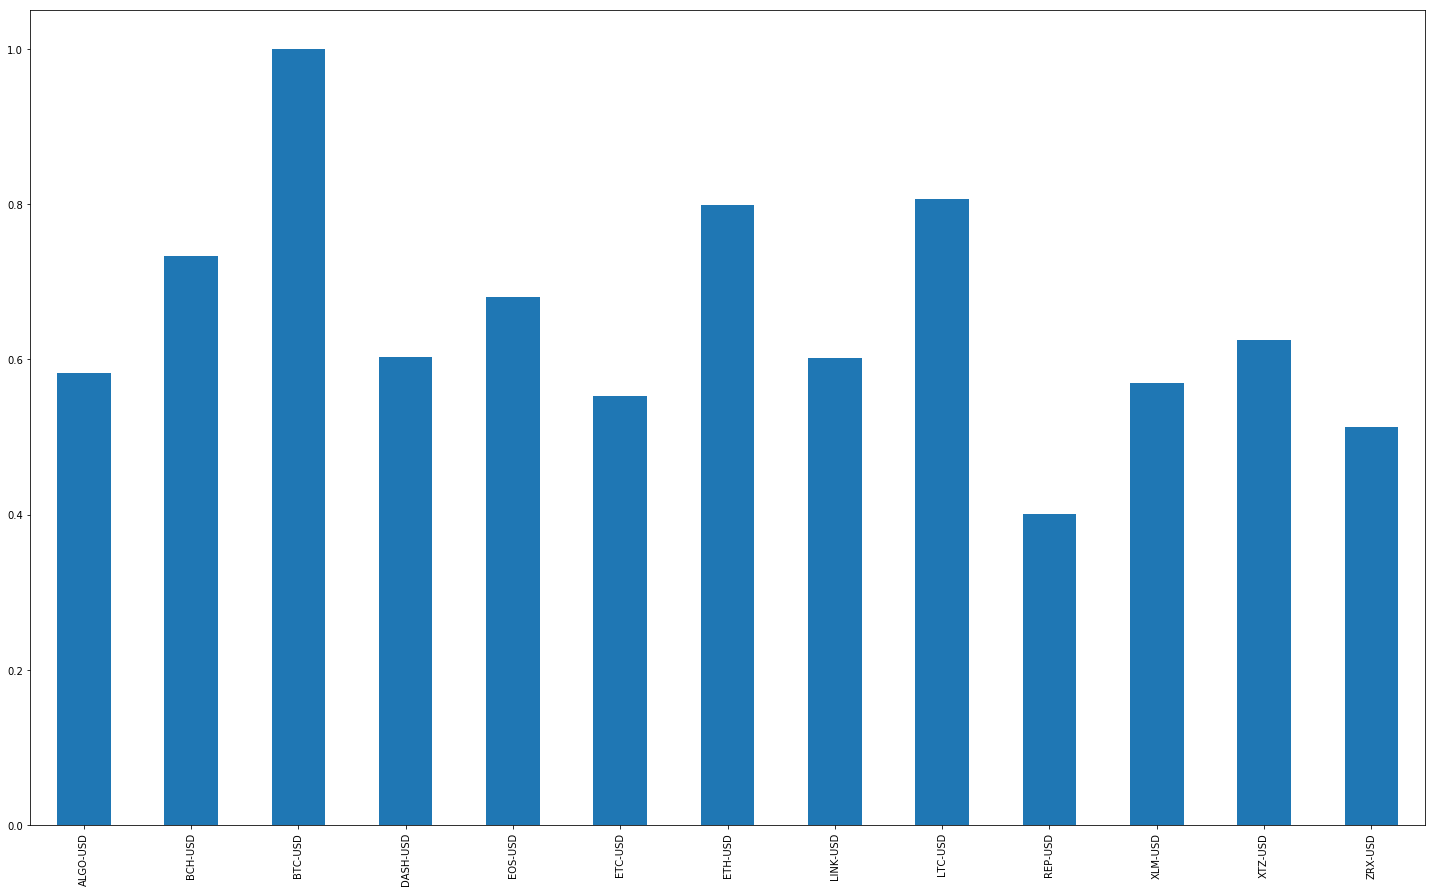

In [17]:
btc_corr = corr['BTC-USD']
btc_corr.plot( kind='bar', figsize=(25,15))



# Create Crypto Portfolios - Starting Capital = $10,000

## Portfolio # 1 - 50% BTC 50% even distributions alts

In [18]:
# Code Here
# Use the `dot` function to multiply the weights by each stock's daily return to get the portfolio daily return
# ALGO-USD	BCH-USD	BTC-USD	DASH-USD EOS-USD ETC-USD ETH-USD LINK-USD LTC-USD REP-USD XLM-USD XTZ-USD ZRX-USD
weights = [(.5/12), (.5/12), .5, (.5/12), (.5/12), (.5/12), (.5/12), (.5/12), (.5/12), (.5/12), (.5/12), (.5/12), (.5/12)]

portfolio_1_returns = cumulative_returns.dot(weights).dropna()
portfolio_1_returns

# calculate end value of portfolio by multiplying the inital investment 10k by the end return


Date
2019-09-18    1.028284
2019-09-19    1.041044
2019-09-20    1.024820
2019-09-21    1.013566
2019-09-22    1.002012
2019-09-23    0.959421
2019-09-24    0.829133
2019-09-25    0.830586
2019-09-26    0.799420
2019-09-27    0.812882
2019-09-28    0.815686
2019-09-29    0.801380
2019-09-30    0.833554
2019-10-01    0.831745
2019-10-02    0.841973
2019-10-03    0.827956
2019-10-04    0.827029
2019-10-05    0.826723
2019-10-06    0.805836
2019-10-07    0.846797
2019-10-08    0.859127
2019-10-09    0.899698
2019-10-10    0.892420
2019-10-11    0.865031
2019-10-12    0.865716
2019-10-13    0.871967
2019-10-14    0.895341
2019-10-15    0.865588
2019-10-16    0.844548
2019-10-17    0.858344
                ...   
2021-07-06    3.915104
2021-07-07    3.893269
2021-07-08    3.721817
2021-07-09    3.803739
2021-07-10    3.747031
2021-07-11    3.804505
2021-07-12    3.663143
2021-07-13    3.578917
2021-07-14    3.590629
2021-07-15    3.461047
2021-07-16    3.370750
2021-07-17    3.383702
2021-0

## Portfolio #2 - 50% BTC 25% ETH 25% evenly distributed Alts - Pete

In [19]:
# Code Here
# Use the `dot` function to multiply the weights by each stock's daily return to get the portfolio daily return
# ALGO-USD	BCH-USD	BTC-USD	DASH-USD EOS-USD ETC-USD ETH-USD LINK-USD LTC-USD REP-USD XLM-USD XTZ-USD ZRX-USD
weights = [(.25/11), (.25/121), .5, (.25/11), (.25/11), (.25/11), .25, (.25/11), (.25/11), (.25/11), (.25/11), (.25/11), (.25/11)]

portfolio_2_returns = cumulative_returns.dot(weights).dropna()
portfolio_2_returns

# calculate end value of portfolio by multiplying the inital investment 10k by the end return


Date
2019-09-18    0.996249
2019-09-19    1.017405
2019-09-20    1.003715
2019-09-21    0.989935
2019-09-22    0.981082
2019-09-23    0.940116
2019-09-24    0.808307
2019-09-25    0.812334
2019-09-26    0.783252
2019-09-27    0.802549
2019-09-28    0.803559
2019-09-29    0.787746
2019-09-30    0.823201
2019-10-01    0.817356
2019-10-02    0.829268
2019-10-03    0.812344
2019-10-04    0.811032
2019-10-05    0.811381
2019-10-06    0.786604
2019-10-07    0.826943
2019-10-08    0.833617
2019-10-09    0.878082
2019-10-10    0.873049
2019-10-11    0.839598
2019-10-12    0.839607
2019-10-13    0.843961
2019-10-14    0.864203
2019-10-15    0.837192
2019-10-16    0.815646
2019-10-17    0.827874
                ...   
2021-07-06    5.403580
2021-07-07    5.378595
2021-07-08    5.045477
2021-07-09    5.143670
2021-07-10    5.066055
2021-07-11    5.147029
2021-07-12    4.924710
2021-07-13    4.773451
2021-07-14    4.839842
2021-07-15    4.665652
2021-07-16    4.562172
2021-07-17    4.597248
2021-0

## Portfolio #3 - Totally even distribution - KAI

In [40]:
# Code Here - KAI
# Use the `dot` function to multiply the weights by each stock's daily return to get the portfolio daily return
# ALGO-USD	BCH-USD	BTC-USD	DASH-USD EOS-USD ETC-USD ETH-USD LINK-USD LTC-USD REP-USD XLM-USD XTZ-USD ZRX-USD
weights = [(1/13), (1/13), (1/13), (1/13), (1/13), (1/13), (1/13), (1/13), (1/13), (1/13), (1/13), (1/13), (1/13)]

portfolio_3_returns = cumulative_returns.dot(weights).dropna()
portfolio_3_returns
# calculate end value of portfolio by multiplying the inital investment 10k by the end return

Portfolio_3 = portfolio_3_returns[-1] * 10000
Portfolio_3

print(f" Portfolio 3 Return is: ${Portfolio_3.round(2)}")


 Portfolio 3 Return is: $49116.16


## Portfolio #4 - Weighted Distribution based on Market Cap - Challenging - Nozie

In [41]:
# Code Here - market cap for each alt/BTC at 2019-09-18 
# Use the `dot` function to multiply the weights by each stock's daily return to get the portfolio daily return
# ALGO-USD	BCH-USD	BTC-USD	DASH-USD EOS-USD ETC-USD ETH-USD LINK-USD LTC-USD REP-USD XLM-USD XTZ-USD ZRX-USD

# Manually enter market caps per alt

# Sum all market caps

# Find out percentage of total market cap for each alt

# set the Percentages equal to the weights

# Figure out weights
weights = [(1/13), (.25/121), .5, (.25/11), (.25/11), (.25/11), .25, (.25/11), (.25/11), (.25/11), (.25/11), (.25/11), (.25/11)]

portfolio_3_returns = cumulative_returns.dot(weights).dropna()
portfolio_3_returns

# calculate end value of portfolio by multiplying the inital investment 10k by the end return

Date
2019-09-18    1.054200
2019-09-19    1.072145
2019-09-20    1.058098
2019-09-21    1.043570
2019-09-22    1.032101
2019-09-23    0.985546
2019-09-24    0.841385
2019-09-25    0.847162
2019-09-26    0.815532
2019-09-27    0.834862
2019-09-28    0.838149
2019-09-29    0.825921
2019-09-30    0.865980
2019-10-01    0.857110
2019-10-02    0.868938
2019-10-03    0.851301
2019-10-04    0.849870
2019-10-05    0.849793
2019-10-06    0.822655
2019-10-07    0.863946
2019-10-08    0.871843
2019-10-09    0.918839
2019-10-10    0.915862
2019-10-11    0.882156
2019-10-12    0.883031
2019-10-13    0.886570
2019-10-14    0.909513
2019-10-15    0.879240
2019-10-16    0.854552
2019-10-17    0.867935
                ...   
2021-07-06    5.558675
2021-07-07    5.532467
2021-07-08    5.192910
2021-07-09    5.297542
2021-07-10    5.217617
2021-07-11    5.299049
2021-07-12    5.072143
2021-07-13    4.922107
2021-07-14    4.985627
2021-07-15    4.807342
2021-07-16    4.695470
2021-07-17    4.730444
2021-0

## Portfolio #5 - Alek - Up to him!

In [22]:
# Code Here - market cap for each alt/BTC at 2019-09-18 
# Use the `dot` function to multiply the weights by each stock's daily return to get the portfolio daily return
# ALGO-USD	BCH-USD	BTC-USD	DASH-USD EOS-USD ETC-USD ETH-USD LINK-USD LTC-USD REP-USD XLM-USD XTZ-USD ZRX-USD
weights = [(1/13), (.25/121), .5, (.25/11), (.25/11), (.25/11), .25, (.25/11), (.25/11), (.25/11), (.25/11), (.25/11), (.25/11)]

portfolio_3_returns = cumulative_returns.dot(weights).dropna()
portfolio_3_returns

# calculate end value of portfolio by multiplying the inital investment 10k by the end return


Date
2019-09-18    1.054200
2019-09-19    1.072145
2019-09-20    1.058098
2019-09-21    1.043570
2019-09-22    1.032101
2019-09-23    0.985546
2019-09-24    0.841385
2019-09-25    0.847162
2019-09-26    0.815532
2019-09-27    0.834862
2019-09-28    0.838149
2019-09-29    0.825921
2019-09-30    0.865980
2019-10-01    0.857110
2019-10-02    0.868938
2019-10-03    0.851301
2019-10-04    0.849870
2019-10-05    0.849793
2019-10-06    0.822655
2019-10-07    0.863946
2019-10-08    0.871843
2019-10-09    0.918839
2019-10-10    0.915862
2019-10-11    0.882156
2019-10-12    0.883031
2019-10-13    0.886570
2019-10-14    0.909513
2019-10-15    0.879240
2019-10-16    0.854552
2019-10-17    0.867935
                ...   
2021-07-06    5.558675
2021-07-07    5.532467
2021-07-08    5.192910
2021-07-09    5.297542
2021-07-10    5.217617
2021-07-11    5.299049
2021-07-12    5.072143
2021-07-13    4.922107
2021-07-14    4.985627
2021-07-15    4.807342
2021-07-16    4.695470
2021-07-17    4.730444
2021-0

## Portfolio #6 - S&P 500 - John

In [23]:
# use the same thing that was done in the homework